In [1]:
import collections
import functools
import statistics
from typing import Callable, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
 * [Substep: EDA](#Substep:-EDA)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-7)
- [Step 8](#Step-8)
- [Step 9](#Step-9)
- [Step 10](#Step-10)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
# disclaimer: may not work as is in Windows OS
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-28 20:21:18--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   905KB/s    in 1.1s    

2022-03-28 20:21:19 (905 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [4]:
# disclaimer: may not work as is in Windows OS
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

The prediction $r_{ui}$ is set as:

$$ r_{ui} = \mu + b_u + b_i + q_{i}^T p_u$$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. 

The same applies for item $i$ with $b_i$ and $q_i$.

To estimate all the unknown, we minimize the following regularized squared error:

$$ \sum_{r_{ui} \in R_{train}} (r_{ui} - \hat{r_{ui}})^2 + \lambda (b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)$$

The minimization is performed by a stochastic gradient descent:

$$ b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$ b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$
$$ p_u \leftarrow p_u + \gamma (e_{ui} q_i - \lambda p_u)$$
$$ q_i \leftarrow q_i + \gamma (e_{ui} p_u - \lambda q_i)$$

where: $e_{ui} = r_{ui} - \hat{r_{ui}}$, $\gamma$ is the learning rate and $\lambda$ the regularization term. These steps are performed over all the ratings of the trainset and repeated $n$ times, where $n$ is the number of epochs.

Baselines are initialized to zero. User and item factors are randomly initialized according to a normal distribution.

[reference](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

## Step 2 + Step 3

In [5]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [6]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

#### Substep: EDA

In [7]:
movielens = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    names=["user", "item", "rating", "timestamp"],
    skiprows=1,
)

inspect_df(movielens)

shape: (100836, 4)


,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movielens[movielens["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])]

,user,item,rating,timestamp
234,2,1704,4.5,1445715228
237,2,8798,3.5,1445714960
240,2,58559,4.5,1445715141
242,2,68157,4.5,1445715154
247,2,80489,4.5,1445715340
...,...,...,...,...
100820,610,160341,2.5,1479545749
100821,610,160527,4.5,1479544998
100826,610,162350,3.5,1493849971
100827,610,163937,3.5,1493848789


In [9]:
print(f"number of users: {len(movielens['user'].unique())}")

number of users: 610


In [10]:
print(f"number of items: {len(movielens['item'].unique())}")

number of items: 9724


In [11]:
movielens["created_at"] = pd.to_datetime(movielens["timestamp"], unit="s")
movielens["created_at"] = pd.to_datetime(movielens["created_at"], format="%Y-%m")

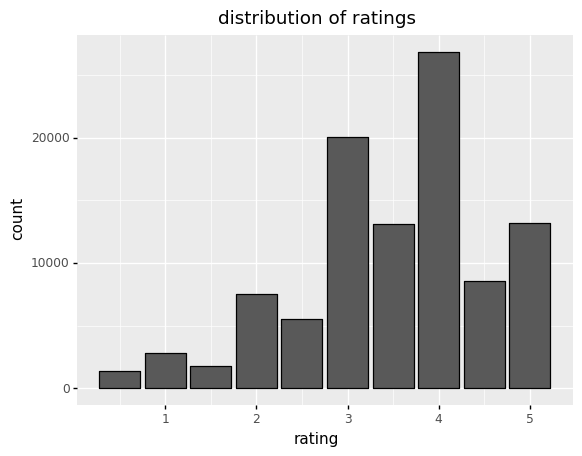

<ggplot: (8783074609652)>

In [12]:
(
    ggplot(movielens, aes(x="rating"))
    + geom_bar(color="black")
    + labs(x="rating", title="distribution of ratings")
)

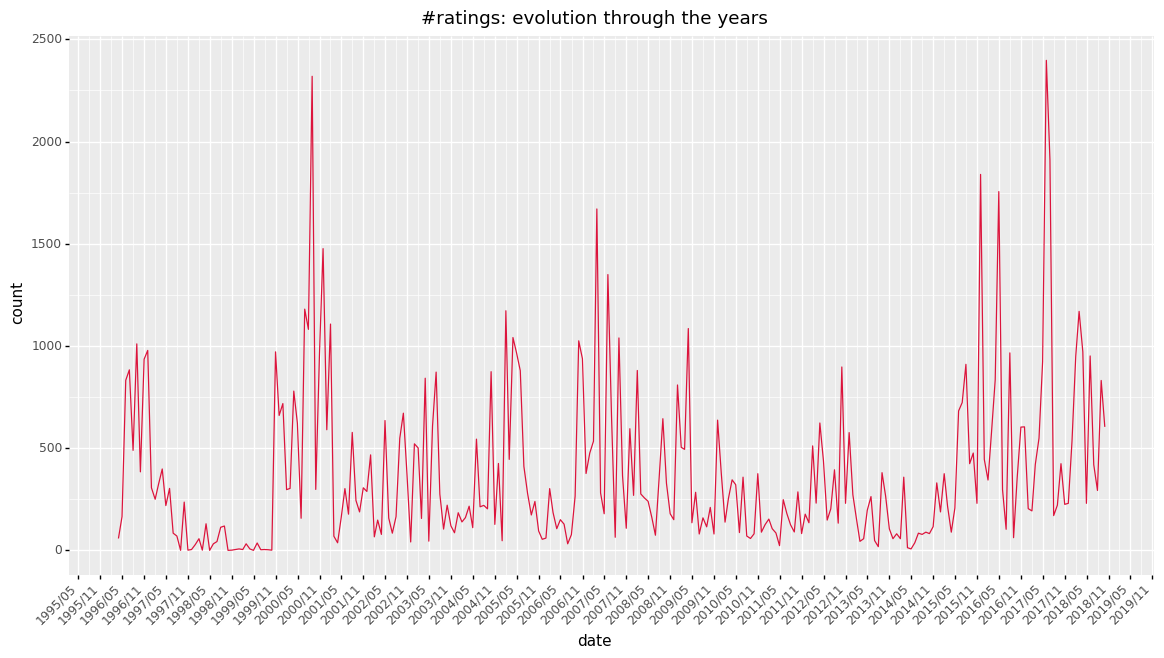

<ggplot: (8782962367136)>

In [13]:
(
    ggplot(
        movielens.groupby(pd.Grouper(key="created_at", freq="M")).count().reset_index()
    )
    + geom_line(aes(x="created_at", y="item"), color="crimson")
    + labs(x="date", y="count", title="#ratings: evolution through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

## Step 4

In [14]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [15]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [16]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7519  0.7530  0.7789  0.7480  0.7594  0.7582  0.0110  
RMSE (testset)    0.8671  0.8678  0.8825  0.8649  0.8715  0.8707  0.0063  
MAE (testset)     0.6653  0.6616  0.6746  0.6603  0.6666  0.6657  0.0051  
MSE (trainset)    0.5074  0.5112  0.5038  0.5103  0.5130  0.5091  0.0033  
RMSE (trainset)   0.7123  0.7150  0.7098  0.7143  0.7163  0.7135  0.0023  
MAE (trainset)    0.5484  0.5509  0.5462  0.5501  0.5508  0.5493  0.0018  
Fit time          1.59    1.60    1.62    1.62    1.62    1.61    0.01    
Test time         0.09    0.11    0.09    0.08    0.10    0.09    0.01    


In [17]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7925  0.7678  0.7939  0.7750  0.7767  0.7812  0.0103  
RMSE (testset)    0.8902  0.8762  0.8910  0.8803  0.8813  0.8838  0.0058  
MAE (testset)     0.6796  0.6703  0.6794  0.6748  0.6729  0.6754  0.0036  
MSE (trainset)    0.3023  0.2996  0.2964  0.2987  0.3002  0.2994  0.0019  
RMSE (trainset)   0.5498  0.5474  0.5444  0.5465  0.5479  0.5472  0.0018  
MAE (trainset)    0.4241  0.4215  0.4199  0.4203  0.4222  0.4216  0.0015  
Fit time          2.97    2.93    2.93    2.96    2.93    2.94    0.02    
Test time         0.09    0.09    0.10    0.09    0.10    0.09    0.00    


In [18]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))
df["mean RMSE (test)"] = df["test_rmse"].map(lambda x: statistics.mean(x))

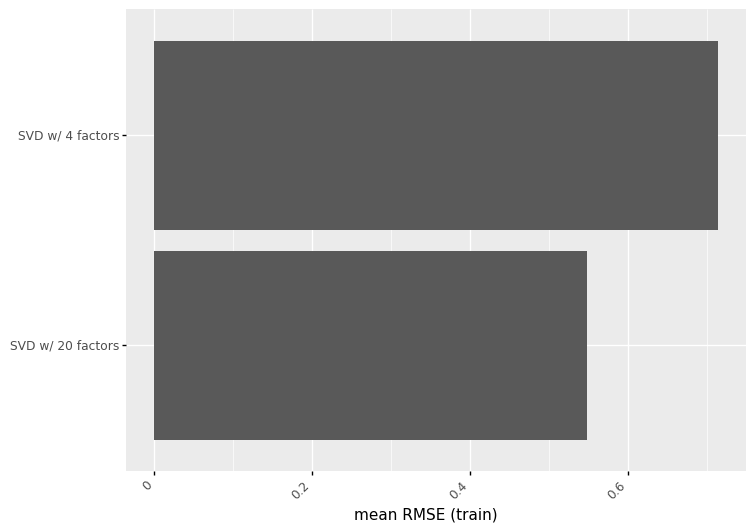

<ggplot: (8782962369702)>

In [19]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

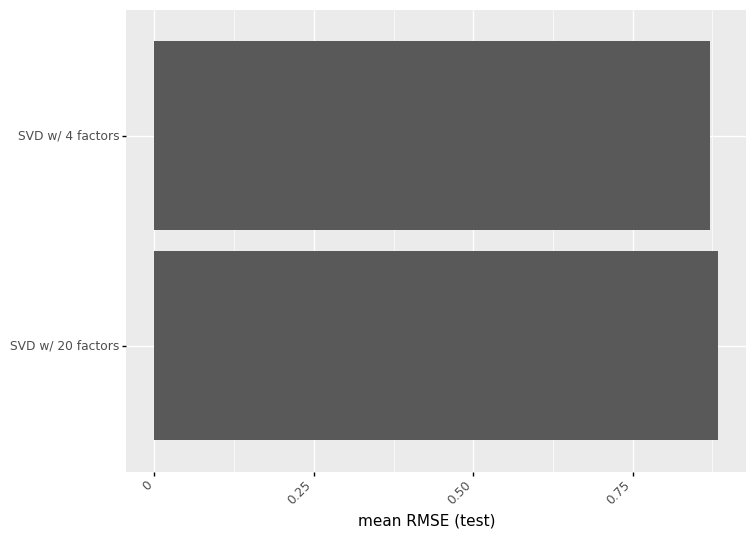

<ggplot: (8783072279293)>

In [20]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (test)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (test)")
    + coord_flip()
)

## Step 5

In [21]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
ratings["user"] = ratings.groupby("user").ngroup()

In [23]:
ratings["item"] = ratings.groupby("item").ngroup()

In [24]:
def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:
    return collections.OrderedDict(
        x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [25]:
def create_tf_datasets(
    data: pd.DataFrame,
    transform_func: Callable,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_client: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["user"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    for _, user_ratings in data.groupby("user"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_client)
            .shuffle(buffer_size=max_items_per_client, seed=42)
            .batch(batch_size)
            .map(transform_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [26]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/val/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)

    train_idx = int(len(tf_datasets) * train_fraction)
    val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

    # Note that the val and test data contains completely different users, not
    # just unseen ratings from train users.
    return (
        tf_datasets[:train_idx],
        tf_datasets[train_idx:val_idx],
        tf_datasets[val_idx:],
    )

In [27]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [28]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

## Step 6

In [29]:
nest_asyncio.apply()

In [30]:
n_users = len(ratings["user"].unique())
n_items = len(ratings["item"].unique())

In [31]:
def matrix_factorization_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A federation-friendly Matrix Factorization model."""
    combined_input = tf.keras.layers.Input(
        shape=[2], dtype="int32", name="combined_input"
    )
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(combined_input[:, 0])
    u = tf.keras.layers.Flatten()(u)

    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(combined_input[:, 1])
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    model = tf.keras.Model(inputs=combined_input, outputs=output)

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 2], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [32]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [34]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [35]:
state = iterative_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 0.01084678, -0.03841866, -0.04076732,  0.03309934],
       [-0.03823245, -0.00671848, -0.02312749,  0.03134521],
       [ 0.04045982,  0.00327549, -0.01606248,  0.00354796],
       ...,
       [-0.01741891,  0.03720889, -0.03083578,  0.03585256],
       [-0.02476226, -0.04415197, -0.01990293,  0.01264579],
       [ 0.01635787, -0.00788043, -0.0056667 ,  0.0037567 ]],
      dtype=float32), array([[ 0.03416027, -0.00515402, -0.0418239 , -0.01269571],
       [-0.03891635,  0.01342383,  0.02612655,  0.02905116],
       [-0.02761699, -0.03777073,  0.04510149, -0.04721833],
       ...,
       [ 0.04690992,  0.0186517 ,  0.01200734, -0.03289314],
       [ 0.01319558,  0.02339238, -0.02774218,  0.00097312],
       [-0.04957446,  0.01397927, -0.01840428, -0.0334455 ]],
      dtype=float32)], non_trainable=[])


In [36]:
print("User variables shape:", state.model.trainable[1].shape)

User variables shape: (611, 4)


In [37]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9725, 4)


In [38]:
evaluation_computation = tff.learning.build_federated_evaluation(model_fn)

In [39]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,2],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [40]:
NUM_ROUNDS = 200  # we will set up a training loop to train over multiple rounds.

In [41]:
train_losses, train_accs = [], []

state = iterative_process.initialize()

for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('root_mean_squared_error', 3.6591842), ('loss', 13.38963), ('num_examples', 8644), ('num_batches', 888)])
Train round 1: OrderedDict([('root_mean_squared_error', 3.6203728), ('loss', 13.1071), ('num_examples', 8908), ('num_batches', 917)])
Train round 2: OrderedDict([('root_mean_squared_error', 3.647559), ('loss', 13.304686), ('num_examples', 9100), ('num_batches', 932)])
Train round 3: OrderedDict([('root_mean_squared_error', 3.6928523), ('loss', 13.637157), ('num_examples', 7853), ('num_batches', 811)])
Train round 4: OrderedDict([('root_mean_squared_error', 3.6223848), ('loss', 13.121673), ('num_examples', 9232), ('num_batches', 947)])
Train round 5: OrderedDict([('root_mean_squared_error', 3.6822832), ('loss', 13.559209), ('num_examples', 8628), ('num_batches', 887)])
Train round 6: OrderedDict([('root_mean_squared_error', 3.7148032), ('loss', 13.799763), ('num_examples', 9198), ('num_batches', 943)])
Train round 7: OrderedDict([('root_mean_squared_erro

2022-03-28 20:23:10.184159: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 36: OrderedDict([('root_mean_squared_error', 3.7703125), ('loss', 14.215257), ('num_examples', 8095), ('num_batches', 832)])
Train round 37: OrderedDict([('root_mean_squared_error', 3.7253802), ('loss', 13.878458), ('num_examples', 7972), ('num_batches', 822)])
Train round 38: OrderedDict([('root_mean_squared_error', 3.7055418), ('loss', 13.731041), ('num_examples', 7593), ('num_batches', 784)])
Train round 39: OrderedDict([('root_mean_squared_error', 3.7590487), ('loss', 14.130448), ('num_examples', 6754), ('num_batches', 702)])
Train round 40: OrderedDict([('root_mean_squared_error', 3.819487), ('loss', 14.588482), ('num_examples', 7282), ('num_batches', 754)])
Train round 41: OrderedDict([('root_mean_squared_error', 3.6423676), ('loss', 13.266842), ('num_examples', 8483), ('num_batches', 873)])
Train round 42: OrderedDict([('root_mean_squared_error', 3.7376688), ('loss', 13.970167), ('num_examples', 7528), ('num_batches', 776)])
Train round 43: OrderedDict([('root_mean_s

2022-03-28 20:24:25.544921: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 70: OrderedDict([('root_mean_squared_error', 3.6153948), ('loss', 13.071079), ('num_examples', 8295), ('num_batches', 852)])
Train round 71: OrderedDict([('root_mean_squared_error', 3.681126), ('loss', 13.550691), ('num_examples', 8651), ('num_batches', 888)])
Train round 72: OrderedDict([('root_mean_squared_error', 3.680751), ('loss', 13.547929), ('num_examples', 7878), ('num_batches', 812)])
Train round 73: OrderedDict([('root_mean_squared_error', 3.6469266), ('loss', 13.300075), ('num_examples', 8332), ('num_batches', 860)])
Train round 74: OrderedDict([('root_mean_squared_error', 3.8645425), ('loss', 14.9346895), ('num_examples', 6991), ('num_batches', 725)])
Train round 75: OrderedDict([('root_mean_squared_error', 3.6586454), ('loss', 13.385686), ('num_examples', 7837), ('num_batches', 807)])
Train round 76: OrderedDict([('root_mean_squared_error', 3.7746487), ('loss', 14.2479725), ('num_examples', 7791), ('num_batches', 802)])
Train round 77: OrderedDict([('root_mean_

Train round 130: OrderedDict([('root_mean_squared_error', 3.5007274), ('loss', 12.255093), ('num_examples', 7413), ('num_batches', 767)])
Train round 131: OrderedDict([('root_mean_squared_error', 3.2038398), ('loss', 10.26459), ('num_examples', 10098), ('num_batches', 1033)])
Train round 132: OrderedDict([('root_mean_squared_error', 3.2738028), ('loss', 10.717785), ('num_examples', 8827), ('num_batches', 906)])
Train round 133: OrderedDict([('root_mean_squared_error', 3.2342818), ('loss', 10.460578), ('num_examples', 9609), ('num_batches', 984)])
Train round 134: OrderedDict([('root_mean_squared_error', 3.193115), ('loss', 10.195984), ('num_examples', 9031), ('num_batches', 929)])
Train round 135: OrderedDict([('root_mean_squared_error', 3.1883194), ('loss', 10.165381), ('num_examples', 8768), ('num_batches', 900)])
Train round 136: OrderedDict([('root_mean_squared_error', 3.1235645), ('loss', 9.756656), ('num_examples', 9600), ('num_batches', 983)])
Train round 137: OrderedDict([('roo

2022-03-28 20:27:34.056865: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 154: OrderedDict([('root_mean_squared_error', 2.982338), ('loss', 8.89434), ('num_examples', 8407), ('num_batches', 864)])
Train round 155: OrderedDict([('root_mean_squared_error', 2.942049), ('loss', 8.655653), ('num_examples', 8324), ('num_batches', 857)])
Train round 156: OrderedDict([('root_mean_squared_error', 3.1129208), ('loss', 9.690276), ('num_examples', 7458), ('num_batches', 771)])
Train round 157: OrderedDict([('root_mean_squared_error', 3.027732), ('loss', 9.167161), ('num_examples', 9386), ('num_batches', 961)])
Train round 158: OrderedDict([('root_mean_squared_error', 3.0243292), ('loss', 9.146567), ('num_examples', 9041), ('num_batches', 927)])
Train round 159: OrderedDict([('root_mean_squared_error', 2.8909092), ('loss', 8.357355), ('num_examples', 10128), ('num_batches', 1036)])
Train round 160: OrderedDict([('root_mean_squared_error', 3.1143801), ('loss', 9.699365), ('num_examples', 7232), ('num_batches', 747)])
Train round 161: OrderedDict([('root_mean_s

2022-03-28 20:28:58.076892: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 189: OrderedDict([('root_mean_squared_error', 2.7510345), ('loss', 7.568191), ('num_examples', 7993), ('num_batches', 825)])
Train round 190: OrderedDict([('root_mean_squared_error', 2.8133984), ('loss', 7.915211), ('num_examples', 8500), ('num_batches', 873)])
Train round 191: OrderedDict([('root_mean_squared_error', 2.6230426), ('loss', 6.8803525), ('num_examples', 9073), ('num_batches', 930)])
Train round 192: OrderedDict([('root_mean_squared_error', 2.6777267), ('loss', 7.170221), ('num_examples', 9521), ('num_batches', 973)])
Train round 193: OrderedDict([('root_mean_squared_error', 2.796887), ('loss', 7.8225765), ('num_examples', 8809), ('num_batches', 904)])
Train round 194: OrderedDict([('root_mean_squared_error', 2.6678412), ('loss', 7.117377), ('num_examples', 10071), ('num_batches', 1031)])
Train round 195: OrderedDict([('root_mean_squared_error', 2.9368687), ('loss', 8.625198), ('num_examples', 7140), ('num_batches', 738)])
Train round 196: OrderedDict([('root_m

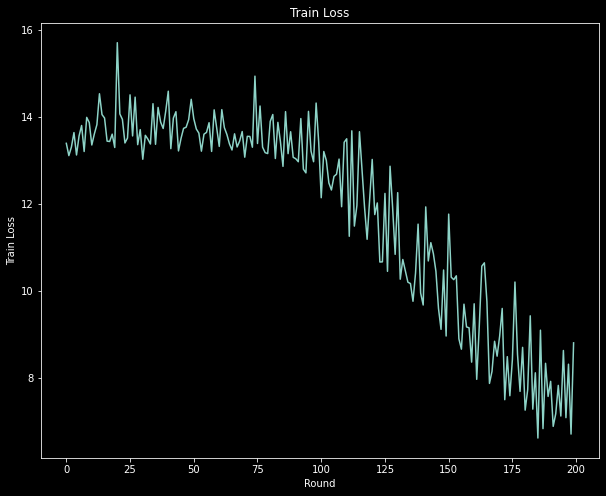

In [42]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

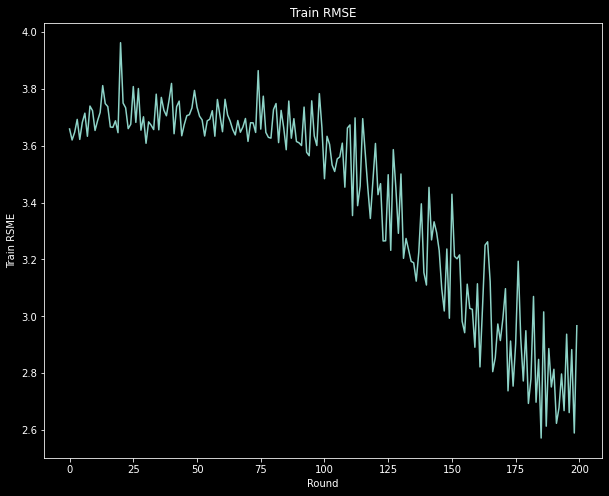

In [43]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [44]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 3.7486799), ('loss', 14.052601), ('num_examples', 1038), ('num_batches', 106)])


In [45]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.809011), ('loss', 14.508565), ('num_examples', 1301), ('num_batches', 134)])


## Step 7

In [46]:
def transform_batch_for_fed_prox(batch: tf.Tensor) -> collections.OrderedDict:
    """we do not need the user since each client will only look at their own data."""
    return collections.OrderedDict(
        x=tf.cast(batch[:, 1:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [47]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch_for_fed_prox,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [48]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

In [49]:
class UserEmbedding(tf.keras.layers.Layer):
    """Keras layer representing an embedding for a single user."""

    def __init__(self, num_latent_factors, **kwargs):
        super().__init__(**kwargs)
        self.num_latent_factors = num_latent_factors

    def build(self, input_shape):
        self.embedding = self.add_weight(
            shape=(1, self.num_latent_factors),
            initializer="uniform",
            dtype=tf.float32,
            name="UserEmbeddingKernel",
        )
        super().build(input_shape)

    def call(self, inputs):
        return self.embedding

    def compute_output_shape(self):
        return (1, self.num_latent_factors)

In [50]:
def matrix_factorization_model_with_user_embedding(
    n_items: int, n_latent_factors: int
) -> tff.learning.Model:

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [51]:
model_fn = functools.partial(
    matrix_factorization_model_with_user_embedding,
    n_items=n_items,
    n_latent_factors=4,
)

In [52]:
fedprox_learning_process = tff.learning.algorithms.build_unweighted_fed_prox(
    model_fn,
    proximal_strength=0.15,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
)

/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:1", shape=(None, 4), dtype=float32), dense_shape=Tensor("PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.


In [53]:
print(fedprox_learning_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9724,4],
      float32[1,4]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    <>,
    <>
  >,
  finalizer=<
    int64
  >
>@SERVER)


In [54]:
evaluation_computation = tff.learning.build_federated_evaluation(
    model_fn,
)

In [55]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9724,4],
      float32[1,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,1],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [56]:
train_losses, train_rmses = [], []

state = fedprox_learning_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    next_state = fedprox_learning_process.next(state, federated_train_data)
    train_losses.append(next_state.metrics["client_work"]["train"]["loss"])
    train_rmses.append(
        next_state.metrics["client_work"]["train"]["root_mean_squared_error"]
    )

model_final_weights = next_state.state.global_model_weights

2022-03-28 20:35:05.611287: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:36:49.880890: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


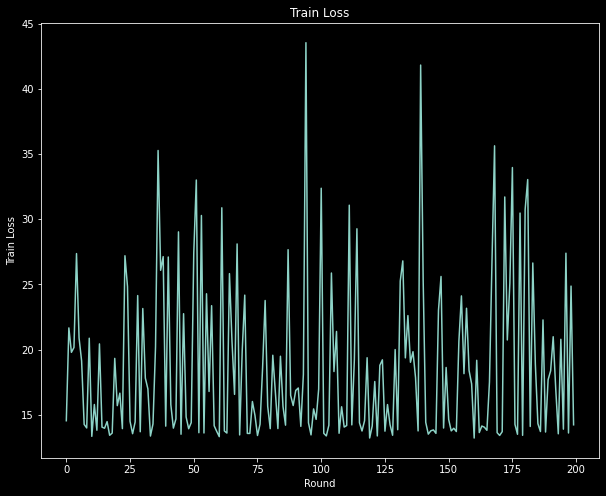

In [57]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

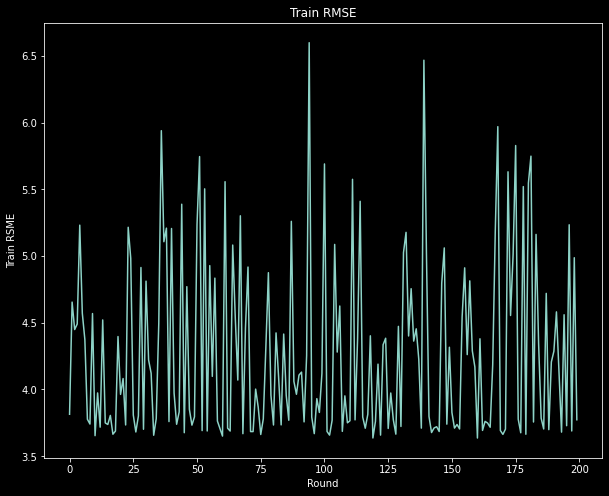

In [58]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [59]:
eval_metrics = evaluation_computation(model_final_weights, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 3.713586), ('loss', 13.790723), ('num_examples', 1038), ('num_batches', 106)])


In [60]:
eval_metrics = evaluation_computation(model_final_weights, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.7655807), ('loss', 14.179598), ('num_examples', 1301), ('num_batches', 134)])


## Step 8

In [61]:
def get_matrix_factorization_reconstruction_model(
    n_items: int, n_latent_factors: int
) -> tff.learning.reconstruction.Model:
    """Defines a Keras matrix factorization model."""
    # layers with variables will be partitioned into global and local layers.
    global_layers = []
    local_layers = []

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    global_layers.append(item_embedding_layer)
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")
    local_layers.append(user_embedding_layer)

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.reconstruction.from_keras_model(
        keras_model=model,
        global_layers=global_layers,
        local_layers=local_layers,
        input_spec=input_spec,
    )

In [62]:
model_fn = functools.partial(
    get_matrix_factorization_reconstruction_model, n_items=n_items, n_latent_factors=4
)

In [63]:
class RatingAccuracy(tf.keras.metrics.Mean):
    """Keras metric computing accuracy of reconstructed ratings."""

    def __init__(self, name: str = "rating_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)

    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ):
        absolute_diffs = tf.abs(y_true - y_pred)
        # A [batch_size, 1] tf.bool tensor indicating correctness within the
        # threshold for each example in a batch. A 0.5 threshold corresponds
        # to correctness when predictions are rounded to the nearest whole
        # number.
        example_accuracies = tf.less_equal(absolute_diffs, 0.5)
        super().update_state(example_accuracies, sample_weight=sample_weight)

In [64]:
loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy(), tf.keras.metrics.RootMeanSquaredError()]

In [65]:
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1),
)

In [66]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [67]:
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(tf.keras.optimizers.SGD, 0.1),
)

In [68]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,1],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  broadcast=<>,
  eval=<
    loss=float32,
    rating_accuracy=float32,
    root_mean_squared_error=float32
  >
>@SERVER)


In [69]:
state = training_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[-0.04876992, -0.01135135,  0.04655564,  0.01579244],
       [ 0.00845801,  0.00922165, -0.03148638, -0.00358286],
       [ 0.04254797,  0.03803888, -0.01619141,  0.00391944],
       ...,
       [-0.00136683,  0.0396695 ,  0.0355662 ,  0.03570597],
       [ 0.00315932, -0.01720027,  0.01508826,  0.03252399],
       [ 0.0024104 , -0.0177955 ,  0.01470839,  0.03012853]],
      dtype=float32)], non_trainable=[])


In [70]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9724, 4)


In [71]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)

In [72]:
print("Initial Eval:", eval_metrics["eval"])

Initial Eval: OrderedDict([('loss', 13.992147), ('rating_accuracy', 0.02414487), ('root_mean_squared_error', 3.7406077)])


In [73]:
federated_train_data = np.random.choice(tf_trainsets, size=50, replace=False).tolist()
state, metrics = training_process.next(state, federated_train_data)

In [74]:
print(f"Train metrics:", metrics["train"])

Train metrics: OrderedDict([('rating_accuracy', 0.004570004), ('root_mean_squared_error', 3.675486), ('loss', 13.509199)])


In [75]:
train_losses, train_accs, train_rmses = [], [], []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = training_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["rating_accuracy"])
    train_rmses.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('rating_accuracy', 0.0039206077), ('root_mean_squared_error', 3.6898398), ('loss', 13.614919)])
Train round 1: OrderedDict([('rating_accuracy', 0.0039556962), ('root_mean_squared_error', 3.643484), ('loss', 13.274977)])
Train round 2: OrderedDict([('rating_accuracy', 0.0066489363), ('root_mean_squared_error', 3.687492), ('loss', 13.597597)])
Train round 3: OrderedDict([('rating_accuracy', 0.0057636886), ('root_mean_squared_error', 3.615678), ('loss', 13.073128)])


2022-03-28 20:38:05.548656: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:38:06.811531: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 4: OrderedDict([('rating_accuracy', 0.0045271628), ('root_mean_squared_error', 3.6851087), ('loss', 13.580026)])
Train round 5: OrderedDict([('rating_accuracy', 0.008012326), ('root_mean_squared_error', 3.7868), ('loss', 14.339853)])
Train round 6: OrderedDict([('rating_accuracy', 0.0088711465), ('root_mean_squared_error', 3.53453), ('loss', 12.492902)])
Train round 7: OrderedDict([('rating_accuracy', 0.009948979), ('root_mean_squared_error', 3.4208326), ('loss', 11.702097)])
Train round 8: OrderedDict([('rating_accuracy', 0.01416943), ('root_mean_squared_error', 3.5207677), ('loss', 12.395806)])
Train round 9: OrderedDict([('rating_accuracy', 0.017539756), ('root_mean_squared_error', 3.2104125), ('loss', 10.306748)])
Train round 10: OrderedDict([('rating_accuracy', 0.067161106), ('root_mean_squared_error', 2.754064), ('loss', 7.5848694)])


2022-03-28 20:38:26.940068: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 11: OrderedDict([('rating_accuracy', 0.11290322), ('root_mean_squared_error', 2.596659), ('loss', 6.742638)])
Train round 12: OrderedDict([('rating_accuracy', 0.12721744), ('root_mean_squared_error', 2.4561465), ('loss', 6.0326557)])


2022-03-28 20:38:32.404872: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 13: OrderedDict([('rating_accuracy', 0.088404134), ('root_mean_squared_error', 2.6291916), ('loss', 6.912649)])
Train round 14: OrderedDict([('rating_accuracy', 0.08939929), ('root_mean_squared_error', 2.6498682), ('loss', 7.021802)])


2022-03-28 20:38:38.295028: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 15: OrderedDict([('rating_accuracy', 0.13196635), ('root_mean_squared_error', 2.4027834), ('loss', 5.773369)])
Train round 16: OrderedDict([('rating_accuracy', 0.16756757), ('root_mean_squared_error', 2.2447886), ('loss', 5.0390763)])
Train round 17: OrderedDict([('rating_accuracy', 0.21029669), ('root_mean_squared_error', 2.0985985), ('loss', 4.4041157)])


2022-03-28 20:38:46.429527: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 18: OrderedDict([('rating_accuracy', 0.23695758), ('root_mean_squared_error', 2.004913), ('loss', 4.019677)])
Train round 19: OrderedDict([('rating_accuracy', 0.22356191), ('root_mean_squared_error', 2.0040212), ('loss', 4.0161014)])
Train round 20: OrderedDict([('rating_accuracy', 0.22899911), ('root_mean_squared_error', 2.062123), ('loss', 4.2523513)])
Train round 21: OrderedDict([('rating_accuracy', 0.26701102), ('root_mean_squared_error', 1.9236059), ('loss', 3.7002597)])


2022-03-28 20:38:56.777317: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 22: OrderedDict([('rating_accuracy', 0.17556286), ('root_mean_squared_error', 2.0748978), ('loss', 4.3052006)])
Train round 23: OrderedDict([('rating_accuracy', 0.17643392), ('root_mean_squared_error', 2.050721), ('loss', 4.2054567)])


2022-03-28 20:39:02.076929: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 24: OrderedDict([('rating_accuracy', 0.2270944), ('root_mean_squared_error', 1.8604689), ('loss', 3.4613442)])
Train round 25: OrderedDict([('rating_accuracy', 0.21934524), ('root_mean_squared_error', 1.917641), ('loss', 3.6773474)])
Train round 26: OrderedDict([('rating_accuracy', 0.24587779), ('root_mean_squared_error', 1.7791498), ('loss', 3.165374)])
Train round 27: OrderedDict([('rating_accuracy', 0.24763033), ('root_mean_squared_error', 1.867068), ('loss', 3.485943)])
Train round 28: OrderedDict([('rating_accuracy', 0.23646724), ('root_mean_squared_error', 1.799794), ('loss', 3.2392583)])
Train round 29: OrderedDict([('rating_accuracy', 0.29835045), ('root_mean_squared_error', 1.7196554), ('loss', 2.9572146)])


2022-03-28 20:39:19.989103: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 30: OrderedDict([('rating_accuracy', 0.30181906), ('root_mean_squared_error', 1.6584038), ('loss', 2.7503033)])
Train round 31: OrderedDict([('rating_accuracy', 0.29026216), ('root_mean_squared_error', 1.6534868), ('loss', 2.7340186)])
Train round 32: OrderedDict([('rating_accuracy', 0.30789766), ('root_mean_squared_error', 1.6163869), ('loss', 2.6127067)])


2022-03-28 20:39:29.240885: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 33: OrderedDict([('rating_accuracy', 0.30863592), ('root_mean_squared_error', 1.6909399), ('loss', 2.859278)])
Train round 34: OrderedDict([('rating_accuracy', 0.3272145), ('root_mean_squared_error', 1.5843703), ('loss', 2.510229)])
Train round 35: OrderedDict([('rating_accuracy', 0.24797161), ('root_mean_squared_error', 1.7005413), ('loss', 2.8918407)])
Train round 36: OrderedDict([('rating_accuracy', 0.21149491), ('root_mean_squared_error', 1.775158), ('loss', 3.151186)])
Train round 37: OrderedDict([('rating_accuracy', 0.33726066), ('root_mean_squared_error', 1.5500671), ('loss', 2.4027078)])
Train round 38: OrderedDict([('rating_accuracy', 0.31947392), ('root_mean_squared_error', 1.5171083), ('loss', 2.3016176)])
Train round 39: OrderedDict([('rating_accuracy', 0.31868988), ('root_mean_squared_error', 1.5792168), ('loss', 2.4939258)])
Train round 40: OrderedDict([('rating_accuracy', 0.3309512), ('root_mean_squared_error', 1.5854081), ('loss', 2.513519)])
Train round 41:

2022-03-28 20:40:04.140806: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 45: OrderedDict([('rating_accuracy', 0.3420939), ('root_mean_squared_error', 1.3889421), ('loss', 1.9291601)])
Train round 46: OrderedDict([('rating_accuracy', 0.3357876), ('root_mean_squared_error', 1.4471595), ('loss', 2.094271)])
Train round 47: OrderedDict([('rating_accuracy', 0.34413728), ('root_mean_squared_error', 1.4357709), ('loss', 2.0614376)])
Train round 48: OrderedDict([('rating_accuracy', 0.2992776), ('root_mean_squared_error', 1.5304532), ('loss', 2.3422868)])
Train round 49: OrderedDict([('rating_accuracy', 0.3289265), ('root_mean_squared_error', 1.5085278), ('loss', 2.275656)])


2022-03-28 20:40:17.494824: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:40:18.571179: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 50: OrderedDict([('rating_accuracy', 0.34161177), ('root_mean_squared_error', 1.4542339), ('loss', 2.1147962)])
Train round 51: OrderedDict([('rating_accuracy', 0.34134737), ('root_mean_squared_error', 1.4619656), ('loss', 2.1373434)])
Train round 52: OrderedDict([('rating_accuracy', 0.34916067), ('root_mean_squared_error', 1.4161013), ('loss', 2.005343)])
Train round 53: OrderedDict([('rating_accuracy', 0.35693413), ('root_mean_squared_error', 1.4123201), ('loss', 1.9946483)])
Train round 54: OrderedDict([('rating_accuracy', 0.37109777), ('root_mean_squared_error', 1.3578563), ('loss', 1.8437738)])
Train round 55: OrderedDict([('rating_accuracy', 0.27446154), ('root_mean_squared_error', 1.5769486), ('loss', 2.486767)])
Train round 56: OrderedDict([('rating_accuracy', 0.32964718), ('root_mean_squared_error', 1.4637573), ('loss', 2.1425853)])
Train round 57: OrderedDict([('rating_accuracy', 0.3773087), ('root_mean_squared_error', 1.3529798), ('loss', 1.8305544)])
Train round

2022-03-28 20:41:18.408920: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 71: OrderedDict([('rating_accuracy', 0.41629386), ('root_mean_squared_error', 1.3127149), ('loss', 1.7232206)])
Train round 72: OrderedDict([('rating_accuracy', 0.38282648), ('root_mean_squared_error', 1.3283771), ('loss', 1.7645859)])


2022-03-28 20:41:23.650951: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 73: OrderedDict([('rating_accuracy', 0.3721591), ('root_mean_squared_error', 1.3364855), ('loss', 1.7861936)])
Train round 74: OrderedDict([('rating_accuracy', 0.4143568), ('root_mean_squared_error', 1.2827138), ('loss', 1.6453546)])


2022-03-28 20:41:29.060958: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 75: OrderedDict([('rating_accuracy', 0.36956522), ('root_mean_squared_error', 1.2727743), ('loss', 1.6199545)])
Train round 76: OrderedDict([('rating_accuracy', 0.3454649), ('root_mean_squared_error', 1.3854979), ('loss', 1.9196045)])
Train round 77: OrderedDict([('rating_accuracy', 0.4008588), ('root_mean_squared_error', 1.294714), ('loss', 1.6762844)])
Train round 78: OrderedDict([('rating_accuracy', 0.35958472), ('root_mean_squared_error', 1.299841), ('loss', 1.6895868)])
Train round 79: OrderedDict([('rating_accuracy', 0.42585286), ('root_mean_squared_error', 1.2093092), ('loss', 1.4624287)])
Train round 80: OrderedDict([('rating_accuracy', 0.3409091), ('root_mean_squared_error', 1.3850377), ('loss', 1.9183294)])
Train round 81: OrderedDict([('rating_accuracy', 0.37909785), ('root_mean_squared_error', 1.273088), ('loss', 1.620753)])
Train round 82: OrderedDict([('rating_accuracy', 0.38189495), ('root_mean_squared_error', 1.329425), ('loss', 1.7673707)])
Train round 83: 

2022-03-28 20:41:53.496874: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 84: OrderedDict([('rating_accuracy', 0.3679494), ('root_mean_squared_error', 1.3015431), ('loss', 1.6940147)])
Train round 85: OrderedDict([('rating_accuracy', 0.3884131), ('root_mean_squared_error', 1.264785), ('loss', 1.5996815)])
Train round 86: OrderedDict([('rating_accuracy', 0.33847016), ('root_mean_squared_error', 1.3921568), ('loss', 1.9381007)])
Train round 87: OrderedDict([('rating_accuracy', 0.42314947), ('root_mean_squared_error', 1.2053475), ('loss', 1.4528626)])
Train round 88: OrderedDict([('rating_accuracy', 0.39341733), ('root_mean_squared_error', 1.2598888), ('loss', 1.5873196)])


2022-03-28 20:42:07.633333: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 89: OrderedDict([('rating_accuracy', 0.45298392), ('root_mean_squared_error', 1.1744939), ('loss', 1.3794361)])


2022-03-28 20:42:11.555928: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 90: OrderedDict([('rating_accuracy', 0.35380116), ('root_mean_squared_error', 1.3980331), ('loss', 1.9544967)])


2022-03-28 20:42:13.234197: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:42:14.302152: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 91: OrderedDict([('rating_accuracy', 0.40024272), ('root_mean_squared_error', 1.2429049), ('loss', 1.5448126)])


2022-03-28 20:42:16.885524: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 92: OrderedDict([('rating_accuracy', 0.3655562), ('root_mean_squared_error', 1.3668762), ('loss', 1.8683507)])
Train round 93: OrderedDict([('rating_accuracy', 0.43007255), ('root_mean_squared_error', 1.2272333), ('loss', 1.5061015)])


2022-03-28 20:42:22.976672: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 94: OrderedDict([('rating_accuracy', 0.38233724), ('root_mean_squared_error', 1.2750797), ('loss', 1.6258284)])
Train round 95: OrderedDict([('rating_accuracy', 0.39854056), ('root_mean_squared_error', 1.313014), ('loss', 1.7240058)])
Train round 96: OrderedDict([('rating_accuracy', 0.4539103), ('root_mean_squared_error', 1.1714101), ('loss', 1.3722014)])
Train round 97: OrderedDict([('rating_accuracy', 0.44044945), ('root_mean_squared_error', 1.2231295), ('loss', 1.496046)])
Train round 98: OrderedDict([('rating_accuracy', 0.39179668), ('root_mean_squared_error', 1.2500259), ('loss', 1.5625646)])
Train round 99: OrderedDict([('rating_accuracy', 0.39394692), ('root_mean_squared_error', 1.2280722), ('loss', 1.5081612)])
Train round 100: OrderedDict([('rating_accuracy', 0.41649377), ('root_mean_squared_error', 1.2294838), ('loss', 1.5116305)])
Train round 101: OrderedDict([('rating_accuracy', 0.43921214), ('root_mean_squared_error', 1.1812027), ('loss', 1.3952398)])


2022-03-28 20:42:45.119536: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 102: OrderedDict([('rating_accuracy', 0.42526597), ('root_mean_squared_error', 1.2446157), ('loss', 1.5490683)])
Train round 103: OrderedDict([('rating_accuracy', 0.42297512), ('root_mean_squared_error', 1.2414984), ('loss', 1.5413182)])


2022-03-28 20:42:49.803313: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 104: OrderedDict([('rating_accuracy', 0.46833882), ('root_mean_squared_error', 1.0921913), ('loss', 1.192882)])
Train round 105: OrderedDict([('rating_accuracy', 0.42842188), ('root_mean_squared_error', 1.2636838), ('loss', 1.5968969)])
Train round 106: OrderedDict([('rating_accuracy', 0.42164782), ('root_mean_squared_error', 1.2647976), ('loss', 1.5997131)])
Train round 107: OrderedDict([('rating_accuracy', 0.4437283), ('root_mean_squared_error', 1.217278), ('loss', 1.4817656)])
Train round 108: OrderedDict([('rating_accuracy', 0.34353092), ('root_mean_squared_error', 1.3752398), ('loss', 1.8912847)])
Train round 109: OrderedDict([('rating_accuracy', 0.4251282), ('root_mean_squared_error', 1.1753167), ('loss', 1.3813695)])
Train round 110: OrderedDict([('rating_accuracy', 0.44508672), ('root_mean_squared_error', 1.1818951), ('loss', 1.3968761)])
Train round 111: OrderedDict([('rating_accuracy', 0.4687368), ('root_mean_squared_error', 1.1231258), ('loss', 1.2614114)])
Train

2022-03-28 20:43:18.176874: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 114: OrderedDict([('rating_accuracy', 0.50281876), ('root_mean_squared_error', 1.1051016), ('loss', 1.2212496)])
Train round 115: OrderedDict([('rating_accuracy', 0.45389903), ('root_mean_squared_error', 1.190328), ('loss', 1.4168807)])
Train round 116: OrderedDict([('rating_accuracy', 0.47619048), ('root_mean_squared_error', 1.1623386), ('loss', 1.3510311)])
Train round 117: OrderedDict([('rating_accuracy', 0.40005416), ('root_mean_squared_error', 1.2340865), ('loss', 1.5229696)])
Train round 118: OrderedDict([('rating_accuracy', 0.471652), ('root_mean_squared_error', 1.155871), ('loss', 1.3360379)])
Train round 119: OrderedDict([('rating_accuracy', 0.46135423), ('root_mean_squared_error', 1.1104909), ('loss', 1.2331902)])
Train round 120: OrderedDict([('rating_accuracy', 0.43992028), ('root_mean_squared_error', 1.2536489), ('loss', 1.5716355)])
Train round 121: OrderedDict([('rating_accuracy', 0.4687842), ('root_mean_squared_error', 1.1015116), ('loss', 1.2133278)])
Train

2022-03-28 20:43:45.170114: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 124: OrderedDict([('rating_accuracy', 0.4243215), ('root_mean_squared_error', 1.2051207), ('loss', 1.452316)])


2022-03-28 20:43:47.766416: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 125: OrderedDict([('rating_accuracy', 0.3720779), ('root_mean_squared_error', 1.326307), ('loss', 1.7590904)])
Train round 126: OrderedDict([('rating_accuracy', 0.45469838), ('root_mean_squared_error', 1.1481229), ('loss', 1.3181862)])
Train round 127: OrderedDict([('rating_accuracy', 0.39689514), ('root_mean_squared_error', 1.2273333), ('loss', 1.5063472)])
Train round 128: OrderedDict([('rating_accuracy', 0.49139833), ('root_mean_squared_error', 1.0714207), ('loss', 1.1479423)])
Train round 129: OrderedDict([('rating_accuracy', 0.48761645), ('root_mean_squared_error', 1.0783265), ('loss', 1.162788)])
Train round 130: OrderedDict([('rating_accuracy', 0.46800646), ('root_mean_squared_error', 1.118287), ('loss', 1.2505658)])
Train round 131: OrderedDict([('rating_accuracy', 0.47614866), ('root_mean_squared_error', 1.2043883), ('loss', 1.4505512)])
Train round 132: OrderedDict([('rating_accuracy', 0.48106956), ('root_mean_squared_error', 1.1084313), ('loss', 1.2286202)])
Trai

2022-03-28 20:44:21.080892: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 137: OrderedDict([('rating_accuracy', 0.41483435), ('root_mean_squared_error', 1.226556), ('loss', 1.5044397)])
Train round 138: OrderedDict([('rating_accuracy', 0.47099236), ('root_mean_squared_error', 1.1290779), ('loss', 1.274817)])
Train round 139: OrderedDict([('rating_accuracy', 0.44078776), ('root_mean_squared_error', 1.128231), ('loss', 1.2729052)])
Train round 140: OrderedDict([('rating_accuracy', 0.46520975), ('root_mean_squared_error', 1.1627579), ('loss', 1.3520058)])
Train round 141: OrderedDict([('rating_accuracy', 0.47490707), ('root_mean_squared_error', 1.0944309), ('loss', 1.197779)])
Train round 142: OrderedDict([('rating_accuracy', 0.48572755), ('root_mean_squared_error', 1.1109715), ('loss', 1.2342575)])
Train round 143: OrderedDict([('rating_accuracy', 0.49337122), ('root_mean_squared_error', 1.0805992), ('loss', 1.1676947)])
Train round 144: OrderedDict([('rating_accuracy', 0.44476002), ('root_mean_squared_error', 1.1806457), ('loss', 1.3939244)])
Trai

2022-03-28 20:44:57.126177: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 150: OrderedDict([('rating_accuracy', 0.50265837), ('root_mean_squared_error', 1.0591532), ('loss', 1.1218055)])


2022-03-28 20:45:00.222107: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 151: OrderedDict([('rating_accuracy', 0.4118404), ('root_mean_squared_error', 1.145175), ('loss', 1.3114257)])
Train round 152: OrderedDict([('rating_accuracy', 0.46116623), ('root_mean_squared_error', 1.0873307), ('loss', 1.1822882)])
Train round 153: OrderedDict([('rating_accuracy', 0.47624907), ('root_mean_squared_error', 1.0650272), ('loss', 1.1342831)])


2022-03-28 20:45:08.001966: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:45:08.081347: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 154: OrderedDict([('rating_accuracy', 0.5138632), ('root_mean_squared_error', 1.0255344), ('loss', 1.0517209)])
Train round 155: OrderedDict([('rating_accuracy', 0.42934266), ('root_mean_squared_error', 1.2510585), ('loss', 1.5651473)])
Train round 156: OrderedDict([('rating_accuracy', 0.49845862), ('root_mean_squared_error', 1.0426191), ('loss', 1.0870547)])
Train round 157: OrderedDict([('rating_accuracy', 0.5158662), ('root_mean_squared_error', 1.0151548), ('loss', 1.0305394)])
Train round 158: OrderedDict([('rating_accuracy', 0.5034613), ('root_mean_squared_error', 1.0079867), ('loss', 1.0160372)])


2022-03-28 20:45:22.230409: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 159: OrderedDict([('rating_accuracy', 0.46268287), ('root_mean_squared_error', 1.0737859), ('loss', 1.1530161)])
Train round 160: OrderedDict([('rating_accuracy', 0.3897979), ('root_mean_squared_error', 1.2231234), ('loss', 1.4960313)])
Train round 161: OrderedDict([('rating_accuracy', 0.53376347), ('root_mean_squared_error', 1.0029627), ('loss', 1.0059342)])
Train round 162: OrderedDict([('rating_accuracy', 0.50361127), ('root_mean_squared_error', 1.010051), ('loss', 1.0202031)])
Train round 163: OrderedDict([('rating_accuracy', 0.4303566), ('root_mean_squared_error', 1.1942719), ('loss', 1.4262855)])
Train round 164: OrderedDict([('rating_accuracy', 0.46650717), ('root_mean_squared_error', 1.0823298), ('loss', 1.1714377)])
Train round 165: OrderedDict([('rating_accuracy', 0.5535755), ('root_mean_squared_error', 0.9659432), ('loss', 0.9330463)])


2022-03-28 20:45:41.939806: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 166: OrderedDict([('rating_accuracy', 0.48033175), ('root_mean_squared_error', 1.0366045), ('loss', 1.074549)])
Train round 167: OrderedDict([('rating_accuracy', 0.45585048), ('root_mean_squared_error', 1.1209667), ('loss', 1.2565663)])
Train round 168: OrderedDict([('rating_accuracy', 0.44692308), ('root_mean_squared_error', 1.1096772), ('loss', 1.2313836)])
Train round 169: OrderedDict([('rating_accuracy', 0.48732394), ('root_mean_squared_error', 1.0385153), ('loss', 1.0785141)])
Train round 170: OrderedDict([('rating_accuracy', 0.5164406), ('root_mean_squared_error', 1.0183102), ('loss', 1.0369558)])
Train round 171: OrderedDict([('rating_accuracy', 0.55628437), ('root_mean_squared_error', 0.9807069), ('loss', 0.96178603)])
Train round 172: OrderedDict([('rating_accuracy', 0.50971395), ('root_mean_squared_error', 1.0801623), ('loss', 1.1667507)])
Train round 173: OrderedDict([('rating_accuracy', 0.45698005), ('root_mean_squared_error', 1.1279972), ('loss', 1.2723776)])


2022-03-28 20:46:03.611493: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 174: OrderedDict([('rating_accuracy', 0.4491785), ('root_mean_squared_error', 1.1466134), ('loss', 1.3147223)])


2022-03-28 20:46:05.944952: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:46:07.532861: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 175: OrderedDict([('rating_accuracy', 0.4357639), ('root_mean_squared_error', 1.1401381), ('loss', 1.2999151)])


2022-03-28 20:46:09.888580: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-28 20:46:10.050033: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 176: OrderedDict([('rating_accuracy', 0.5180291), ('root_mean_squared_error', 1.0138152), ('loss', 1.0278213)])
Train round 177: OrderedDict([('rating_accuracy', 0.56147623), ('root_mean_squared_error', 0.94915855), ('loss', 0.900902)])
Train round 178: OrderedDict([('rating_accuracy', 0.44427294), ('root_mean_squared_error', 1.1355561), ('loss', 1.2894876)])
Train round 179: OrderedDict([('rating_accuracy', 0.47491995), ('root_mean_squared_error', 1.0767766), ('loss', 1.159448)])
Train round 180: OrderedDict([('rating_accuracy', 0.4707344), ('root_mean_squared_error', 1.0735352), ('loss', 1.152478)])
Train round 181: OrderedDict([('rating_accuracy', 0.43473125), ('root_mean_squared_error', 1.0931826), ('loss', 1.1950482)])
Train round 182: OrderedDict([('rating_accuracy', 0.38884786), ('root_mean_squared_error', 1.2468021), ('loss', 1.5545155)])
Train round 183: OrderedDict([('rating_accuracy', 0.4353925), ('root_mean_squared_error', 1.0941926), ('loss', 1.1972576)])
Train

2022-03-28 20:46:53.275617: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 191: OrderedDict([('rating_accuracy', 0.5358509), ('root_mean_squared_error', 1.0408123), ('loss', 1.0832903)])
Train round 192: OrderedDict([('rating_accuracy', 0.5313539), ('root_mean_squared_error', 0.9831684), ('loss', 0.96662015)])
Train round 193: OrderedDict([('rating_accuracy', 0.52186924), ('root_mean_squared_error', 0.97878736), ('loss', 0.9580248)])
Train round 194: OrderedDict([('rating_accuracy', 0.5261739), ('root_mean_squared_error', 0.98719674), ('loss', 0.97455746)])
Train round 195: OrderedDict([('rating_accuracy', 0.54578847), ('root_mean_squared_error', 0.97932625), ('loss', 0.9590799)])
Train round 196: OrderedDict([('rating_accuracy', 0.53366524), ('root_mean_squared_error', 0.9797067), ('loss', 0.9598253)])
Train round 197: OrderedDict([('rating_accuracy', 0.45816734), ('root_mean_squared_error', 1.0828043), ('loss', 1.1724653)])
Train round 198: OrderedDict([('rating_accuracy', 0.5167851), ('root_mean_squared_error', 1.0416163), ('loss', 1.0849645)])

2022-03-28 20:47:14.808893: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 199: OrderedDict([('rating_accuracy', 0.524643), ('root_mean_squared_error', 0.98984814), ('loss', 0.9797994)])


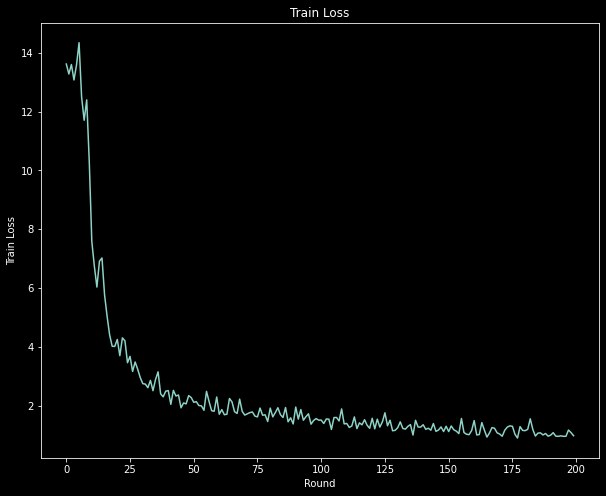

In [76]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

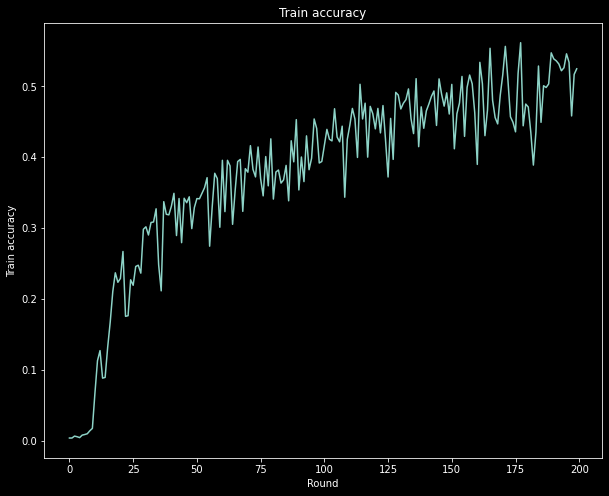

In [77]:
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train accuracy")
plt.xlabel("Round")
plt.title("Train accuracy")
plt.show()

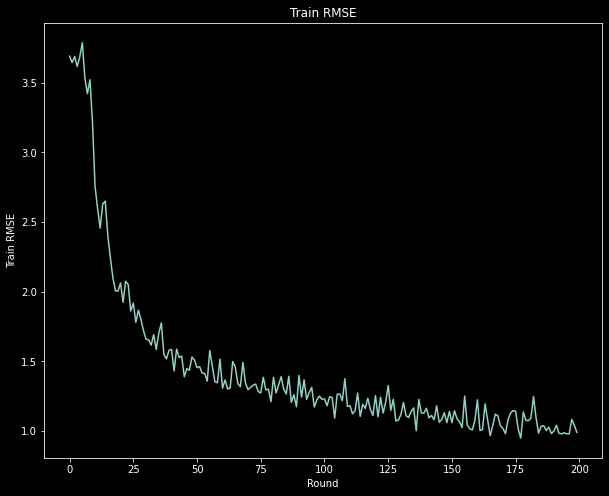

In [78]:
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RMSE")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [79]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('loss', 2.936847), ('rating_accuracy', 0.30985916), ('root_mean_squared_error', 1.7137232)])


In [80]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('loss', 2.5063703), ('rating_accuracy', 0.2608), ('root_mean_squared_error', 1.5831519)])


## Step 9

In [81]:
# already incorporated in previous steps

## Step 10

In [82]:
# report